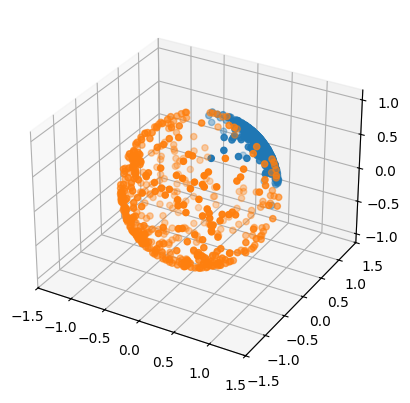

In [1]:
import numpy as np
import pylab as pl
import math as mt

class vMFrand:
    """ sample from von Mises-Fisher distribution using Metropolis algorithm
    """
    def __init__(self,d = 3, num =1000, k = 20, mu = np.array([0])):
        self.d = d
        self.num = num
        self.k = k
        if np.size(mu) == 1:
            self.mu = np.ones(self.d)
            self.mu = self.mu/np.linalg.norm(self.mu)
        else:
            self.mu = mu
        self.seed = self.new()

    def func(self,x):
        return mt.exp( self.k * np.dot(self.mu.T,x))

    def new(self):
        x = np.random.random((self.d,)) - 0.5
        return x/np.linalg.norm(x)

    def metro(self,old):
        while(1):
            n = self.new()
            trans = np.amin([1, self.func(n)/self.func(old)])

            if(trans > np.random.random()):
                return n

    def rand(self):
        von = np.zeros((self.num, self.d))
        von[0] = self.seed
        for i in range(self.num-1):
            von[i+1] = self.metro(von[i])
        return von

vmfrand = vMFrand(num = 500)
von = vmfrand.rand()

fig = pl.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(von[:,0],von[:,1],von[:,2])

vmfrand = vMFrand(d = 3, num = 500,k = 1,mu = np.array([-1,-1,-1]))
von = vmfrand.rand()
ax.scatter(von[:,0],von[:,1],von[:,2])

pl.xlim(-1.5,1.5)
pl.ylim(-1.5,1.5)

pl.show()


In [2]:
import numpy as np
from sklearn.metrics.cluster import contingency_matrix

def purity_score(k, y_true, y_pred):
    """ Calculate the purity score of a clustering result.
    """
    cm = contingency_matrix(y_true, y_pred)
    return cm.max(axis=0).sum() / cm.sum()


In [ ]:
# ------------------------------------------
#  SX-means ― Table 2 
#  requirements: numpy, scipy (>=1.6), sklearn, matplotlib  
# ------------------------------------------
import numpy as np
from sxmeans import SXMEANS
from tabulate import tabulate          # pip install tabulate

# ---------- 1. True parameters (Table 1) ----------
DIM      = 3
CLUSTERS = [
    dict(N=700, mu=np.array([ 0,  0, -1]), kappa=100),
    dict(N=600, mu=np.array([ 1,  0,  0]), kappa=40 ),
    dict(N=400, mu=np.array([-1,  0,  0]), kappa=60 ),
    dict(N=300, mu=np.array([ 0,  0,  1]), kappa=80 )
]

# ---------- 2. Synthetic Data Generation ----------
X_list = []
for c in CLUSTERS:
    vm  = vMFrand(d=DIM, num=c["N"], k=c["kappa"], mu=c["mu"])
    X_list.append(vm.rand())
X = np.vstack(X_list)                        # (2000, 3)

# ---------- 3. Run SX-means ----------
sx = SXMEANS(X)
sx.sxmeans()                                 # We obtain sx.k, sx.class_num.

# ---------- 4. Estimate Ni, μi, κi for each cluster ----------
def estimate_kappa(cluster_points):
    r_bar = np.linalg.norm(cluster_points.mean(axis=0))
    return r_bar*(DIM - r_bar**2)/(1 - r_bar**2)

rows = []
for i in range(sx.k):
    mask   = sx.class_num == i
    pts    = X[mask]
    Ni     = pts.shape[0]
    mu_hat = pts.mean(axis=0)
    mu_hat /= np.linalg.norm(mu_hat)
    kappa  = estimate_kappa(pts)
    rows.append([i+1, Ni, tuple(np.round(mu_hat, 5)), np.round(kappa, 2)])

# Sort clusters in descending order of cluster size, as in Table 2
rows.sort(key=lambda r: r[1], reverse=True)   
for new_i, r in enumerate(rows, start=1):     
    r[0] = new_i

# ---------- 5. 表形式で出力 ----------
headers = ["i", "N̂i", "μ̂i", "κ̂i"]
print("\nTrue parameters (Table 1)\n")
# Convert numpy arrays to tuples for tabulate compatibility
print(tabulate([(i+1, c["N"], tuple(np.round(c["mu"], 5)), c["kappa"]) for i, c in enumerate(CLUSTERS)],
               headers=["i", "Ni", "μi", "κi"], tablefmt="github"))

print("\nEstimated parameters (Table 2 reproduction)\n")
print(tabulate(rows, headers, tablefmt="github"))



True parameters (Table 1)

|   i |   Ni | μi                                       |   κi |
|-----|------|------------------------------------------|------|
|   1 |  700 | (np.int64(0), np.int64(0), np.int64(-1)) |  100 |
|   2 |  600 | (np.int64(1), np.int64(0), np.int64(0))  |   40 |
|   3 |  400 | (np.int64(-1), np.int64(0), np.int64(0)) |   60 |
|   4 |  300 | (np.int64(0), np.int64(0), np.int64(1))  |   80 |

Estimated parameters (Table 2 reproduction)

|   i |   N̂i | μ̂i                                                                |    κ̂i |
|-----|------|-------------------------------------------------------------------|-------|
|   1 |  699 | (np.float64(-0.0055), np.float64(0.00602), np.float64(-0.99997))  | 66.21 |
|   2 |  600 | (np.float64(0.99998), np.float64(-0.00625), np.float64(-0.0017))  | 22.29 |
|   3 |  400 | (np.float64(-0.99998), np.float64(0.00103), np.float64(-0.00566)) | 31.36 |
|   4 |  301 | (np.float64(0.00514), np.float64(-0.0095), np.float64(0.99994))

In [5]:
# table3_driver.py  ----------------------------------------------------------
import numpy as np
from tabulate import tabulate
#from sxmeans import SXMEANS
#from vmfrand import vMFrand

np.random.seed(0)                    

DIM        = 3                        # dimension
POINTS_PER = 500                      # sample size per cluster
KAPPA_GEN  = 100                      # kappa for generating clusters
TRIALS     = 10                        # 1 trial per true k

true_ks = range(2, 13)                # 2〜12

methods = {
    "SX-means":          dict(fixed=False),
    "fixed κ=10":        dict(fixed=True,  fixed_kappa=10),
    "fixed κ=40":        dict(fixed=True,  fixed_kappa=40),
}

# Result table: rows = true k, columns = each method (mean, std)
results = {m: {"mean": [], "std": []} for m in methods}

# ------------------------------------------------------------
for k_true in true_ks:
    print(f"true k = {k_true}")
    ks_est = {m: [] for m in methods}

    for _ in range(TRIALS):
        # ----- データ生成 -----
        X_list = []
        mu_sampler = vMFrand(d=DIM)          
        for _ in range(k_true):
            mu = mu_sampler.new()            
            vm = vMFrand(d=DIM, k=KAPPA_GEN,
                          num=POINTS_PER, mu=mu)
            X_list.append(vm.rand())
        X = np.vstack(X_list)                # (k_true*500, 3)

        # ----- Run each method -----
        for name, kwargs in methods.items():
            try:
                sx = SXMEANS(X, **kwargs)
                sx.sxmeans()
                ks_est[name].append(sx.k)
            except IndexError:
                # Ignore cases where only one cluster is found and cannot be split
                ks_est[name].append(np.nan)

    for name in methods:
        valid_ks = [k for k in ks_est[name] if not np.isnan(k)]
        mean_k = np.mean(valid_ks) if valid_ks else np.nan
        std_k  = np.std(valid_ks) if valid_ks else np.nan
        results[name]["mean"].append(mean_k)
        results[name]["std"].append(std_k)

# ------------------------------------------------------------
rows = []
for idx, k_true in enumerate(true_ks):
    row = [k_true]
    for name in methods:
        m = results[name]["mean"][idx]
        s = results[name]["std"][idx]
        row.append(f"{m:.2f} ({s:.3f})")
    rows.append(row)

headers = ["true k"] + list(methods.keys())
print("\nTable 3 (reproduced, 20 runs each)\n")
print(tabulate(rows, headers, tablefmt="github"))


true k = 2
true k = 3
true k = 4
true k = 5
true k = 6
true k = 7


/Users/k-z/GitHub/SX-means/sxmeans.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  return r*(d - r*r)/(1 - r*r)
/Users/k-z/GitHub/SX-means/sxmeans.py:116: RuntimeWarning: invalid value encountered in scalar subtract
  ll += rns[j] * (mt.log(rns[j]) - mt.log(rn) - (self.DIM - 1) / 2.0 * mt.log(2*mt.pi) + (self.DIM-1) / 2.0 * mt.log(kappas[j]) - kappas[j]) + kappas[j] * np.sum(np.dot(ci[mask2], u[i][j]))


true k = 8
true k = 9
true k = 10
true k = 11
true k = 12

Table 3 (reproduced, 20 runs each)

|   true k | SX-means      | fixed κ=10   | fixed κ=40    |
|----------|---------------|--------------|---------------|
|        2 | 2.00 (0.000)  | 2.00 (0.000) | 2.00 (0.000)  |
|        3 | 3.00 (0.000)  | 2.80 (0.400) | 3.00 (0.000)  |
|        4 | 3.90 (0.300)  | 3.40 (0.490) | 3.80 (0.400)  |
|        5 | 4.60 (0.490)  | 4.00 (0.775) | 4.60 (0.490)  |
|        6 | 5.90 (0.300)  | 4.90 (0.700) | 5.89 (0.314)  |
|        7 | 6.10 (0.831)  | 4.40 (0.663) | 5.90 (0.943)  |
|        8 | 7.30 (0.900)  | 5.10 (0.831) | 7.10 (0.831)  |
|        9 | 8.30 (0.458)  | 5.20 (0.748) | 8.20 (0.600)  |
|       10 | 8.90 (0.943)  | 5.70 (1.187) | 8.90 (1.136)  |
|       11 | 9.10 (1.578)  | 5.70 (1.187) | 9.70 (3.002)  |
|       12 | 10.40 (1.562) | 6.40 (1.020) | 10.00 (1.265) |
